In [1]:
import numpy as np
import subprocess
import os

DELETE_TEMP = False

ORCA_PATH = "/home/gui/orca_6_0_1/"
ORCA_EXEC = ORCA_PATH+"orca"

NMR_INPUT = "acetamide_nmr_c.inp"
NMR_OUTPUT = "acetamide_nmr_c.out"
NMR_SPEC_INPUT = "acetamide_c.nmrspec"
NMR_GBW_FILE = "acetamide_nmr_c.gbw"
NMR_SPEC_OUTPUT = "acetamide_c_nmrspec.out"

# create input file for NMR shieldings
nmr_inp = '''
!B3LYP 6-31G*
*xyz 0 1
  O          -0.46269991708219      1.26347851821489     -0.25636278872658
  N           0.71857458246431     -0.66376635191250      0.05627510754746
  C          -0.44155497151501      0.05063526848618     -0.08649725038021
  C           2.02871261396007     -0.03987380453501      0.02291345938059
  C          -1.72204540274477     -0.77251562482314     -0.02173604985495
  H           0.66014801076857     -1.66095160782806      0.19945565079693
  H           2.55818083398569     -0.16816058626330      0.97543308336928
  H           1.87254650126915      1.02501026444747     -0.15753197370456
  H           2.64664219040216     -0.45496754358063     -0.78286182010502
  H          -2.34765828014480     -0.38714532433314      0.78968161181891
  H          -2.27740323351236     -0.63290341950480     -0.95471645016362
  H          -1.55704292785082     -1.84383978836795      0.13564742002177
* 

%eprnmr
 Nuclei = all C {shift}
end
'''

with open(NMR_INPUT,"w") as f:
    f.write(nmr_inp)

with open(NMR_OUTPUT,"w") as f_o:
# run orca for NMR shieldings
    subprocess.run([ORCA_EXEC, NMR_INPUT], stdout = f_o)

In [2]:
# calculate TMS as reference
TMS_INPUT = "tms_nmr_c.inp"
TMS_OUTPUT = "tms_nmr_c.out"

tms_inp = '''
!B3LYP 6-31G*
*xyz 0 1
  Si         -0.00016217760413     -0.00000200966369     -0.00001724916921
  C          -0.00000381060783     -0.00000292410772      1.87604035066756
  C           1.76890263153042     -0.00000220438520     -0.62476798792801
  C          -0.88452969047227     -1.53170003319882     -0.62565336419779
  C          -0.88451803763557      1.53170284867113     -0.62564941393828
  H          -1.02024320585180     -0.00004763673129      2.26807747150872
  H           0.51041349194385      0.88367742102248      2.26744728207030
  H           0.51049406579855     -0.88363545598283      2.26744932583441
  H           1.79889713542055     -0.00002636281349     -1.71733986918209
  H           2.30802219317048      0.88363945655706     -0.27386690302155
  H           2.30803592092593     -0.88361814255887     -0.27382577782536
  H          -0.90062854341904     -1.55578670297871     -1.71826319426016
  H          -1.91903757060460     -1.55776918964915     -0.27388248209104
  H          -0.38800706817058     -2.44075463393491     -0.27679593332374
  H          -0.90062145682280      1.55579443985819     -1.71826001944301
  H          -1.91902290654613      1.55778308725346     -0.27387187984590
  H          -0.38798097105504      2.44074804264236     -0.27679035585484
* 

%eprnmr
 Nuclei = all C {shift}
end
'''

with open(TMS_INPUT,"w") as f:
    f.write(tms_inp)

with open(TMS_OUTPUT,"w") as f_o:
    subprocess.run([ORCA_EXEC, TMS_INPUT], stdout = f_o)

# read the isotropic values from the output
isotropic_values = []

with open(TMS_OUTPUT, "r") as f_o:
    lines = f_o.readlines()

in_section = False
for i, line in enumerate(lines):
    if "Nucleus  Element    Isotropic     Anisotropy" in line:
        in_section = True
        continue
    if in_section:
        parts = line.split()
        if parts and parts[0].isdigit():
            try:
                isotropic_values.append(float(parts[2]))
            except (IndexError, ValueError):
                pass
        if not line.strip():
            break

# calculate the average
if isotropic_values:
    average_isotropic = sum(isotropic_values) / len(isotropic_values)
    print(f"The reference value is: {average_isotropic:.2f} (ppm)")
else:
    print("No isotropic values found.")

The reference value is: 191.34 (ppm)


In [3]:
ORCA_NMRSPC = ORCA_PATH+"orca_nmrspectrum"

# create input file for orca_nmrspectrum
nmr_spec_inp = '''
NMRShieldingFile = "acetamide_nmr_c"
NMRCouplingFile = "acetamide_sscc_h"
NMRSpecFreq = 80.00
PrintLevel = 0
NMRCoal = 1.0
NMRREF[6] 191.34
END
'''

with open(NMR_SPEC_INPUT,"w") as f:
    f.write(nmr_spec_inp)

with open(NMR_SPEC_OUTPUT,"w") as f_o:
# run orca_nmrspectrum (there is a bug in this version)
    subprocess.run([ORCA_NMRSPC, NMR_GBW_FILE, NMR_SPEC_INPUT], stdout = f_o)

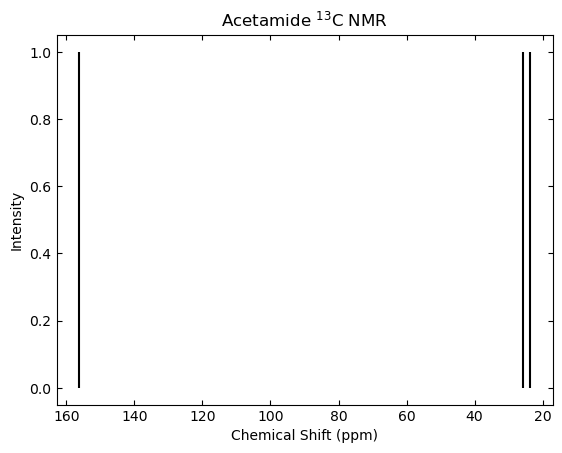

In [5]:
# read hydrogen data from the output
import csv
carbon_data = []

with open("acetamide_c_nmrspec.out","r") as f:
    lines = f.readlines()

inside_carbon_section = False
for i, line in enumerate(lines):
    if "NMR Peaks for atom type 6" in line:
        inside_carbon_section = True
        continue
    if inside_carbon_section:
        parts = line.split()        
        if len(parts) == 3:
            try:
               atom, shift_ppm, rel_intensity = int(parts[0]), float(parts[1]), float(parts[2])
               carbon_data.append((shift_ppm, rel_intensity))
            except ValueError:
               continue
        if "NMR Peaks for atom type" in line:
            inside_hydrogen_section = False
            break

with open("carbon_data.csv", "w", newline="") as f:
    writer = csv.writer(f, delimiter=' ')
    writer.writerows(carbon_data)

if not carbon_data: 
    print("No carbon data found.")

# plot the NMR spectrum
from importlib import reload
import ConvolutionPlot
                       
reload(ConvolutionPlot) 
from ConvolutionPlot import * 

ConvPlot(SpecType = 4, gamma = 0.0, PlotTitle = "Acetamide $^{13}$C NMR", PlotLabel = ["B3LYP/6-31G*"], 
            DataFileNames=["carbon_data.csv"])